# Read IMERG

In [ ]:
import h5py
from glob import glob

In [ ]:
glob(pathname='./data/imerg/*/*/')

In [ ]:
f = h5py.File('./data/imerg/3B-HHR.MS.MRG.3IMERG.20200101-S000000-E002959.0000.V06B.HDF5', 'r')
list(f['Grid'])

In [ ]:
f['Grid']['lon'], f['Grid']['lat'], f['Grid']['precipitationCal'], f['Grid']['precipitationUncal']

# READ GSMaP

In [2]:
import netCDF4
nc=netCDF4.Dataset('data/gsmap/2022/01/01/gsmap_now_rain.20220101.0000.nc','r')
Lon=nc.variables['Longitude'][:]
Lat=nc.variables['Latitude'][:]
hourlyPrecipRateGC=nc.variables['hourlyPrecipRateGC'][:]
hourlyPrecipRate=nc.variables['hourlyPrecipRate'][:]
nc.close()

In [3]:
Lon.shape, Lat.shape, hourlyPrecipRateGC.shape, hourlyPrecipRate.shape

((3600,), (1800,), (1, 1800, 3600), (1, 1800, 3600))

## Plot with basemap

In [4]:
def plot(lon, lat, values):
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from mpl_toolkits.basemap import Basemap

    #plot with Matplotlib
    fig=plt.figure(figsize=(20,20))
    # set the color interval
    interval=list(np.arange(1,30,1)) 
    interval.insert(0,0.1)
    #set colormap
    cmap = mpl.cm.get_cmap("jet").copy()
    cmap.set_under('w', alpha=0)
    #set map
    m=Basemap(projection='cyl',
            resolution='c',
            llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(color='black')
    m.drawmeridians(np.arange(0,360,30))
    m.drawparallels(np.arange(-90,90,30))
    x,y=m(Lon, Lat) #compute map projection
    im=plt.contourf(x,y,values, interval, cmap=cmap) 
    # set colorbar
    cb=m.colorbar(im, "right", size="2.5%")
    # plt.show()

In [5]:
plot(f['Grid']['lon'], f['Grid']['lat'], f['Grid']['precipitationUncal'][0].T)

NameError: name 'f' is not defined

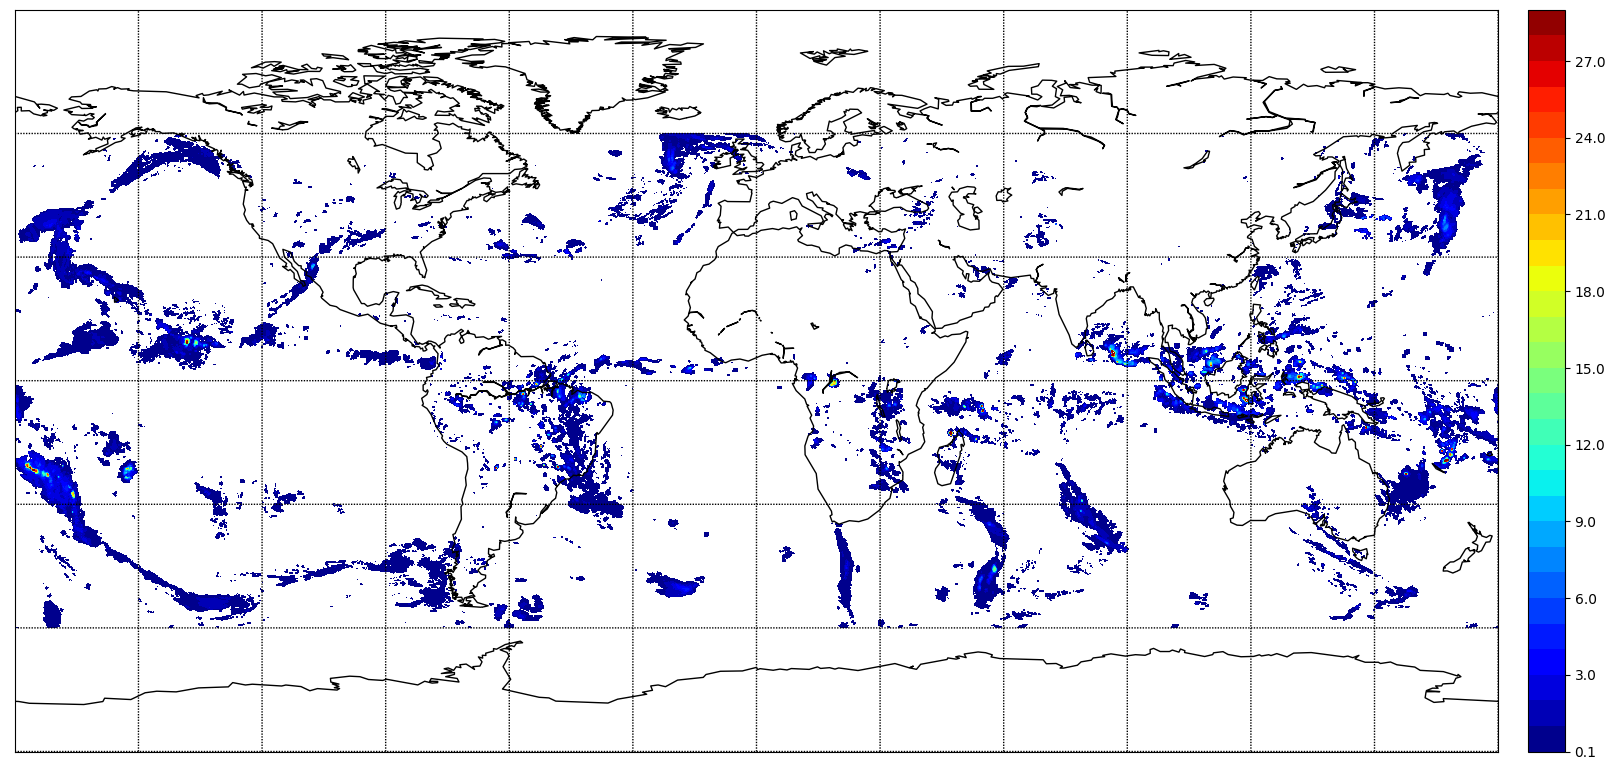

In [6]:
plot(Lon, Lat, hourlyPrecipRateGC[0])

In [ ]:
plot(Lon, Lat, hourlyPrecipRate[0])

## Convert IMERG to csv

In [1]:
import h5py
def imergs_to_numpy(imerg_data):
    import numpy as np
    # import pandas as pd
    # import os
    lons = np.array(list(imerg_data['Grid']['lon']))
    lats = np.array(imerg_data['Grid']['lat'])
    values = np.array(imerg_data['Grid']['precipitationCal'])

    data = merge_arrays(lons, lats, values)
    return data
    # df = pd.DataFrame(data=data, columns=['lon','lat','value'])
    # destination_path = os.path.join(base_data_path, f"{destination}.csv")
    # df.to_csv(destination_path)

def merge_arrays(a,b,c):
    import numpy as np
    # create a products of 'a' and 'b'
    # if lons = [1,2,3] and lats = [a,b]
    # result is
    # [[1, a],
    # [1, b],
    # [2, a],
    # [2, b],
    # [3, a],
    # [3, b]]
    products = np.array(np.meshgrid(a,b)).T.reshape(-1,2)
    # reshape 'c' that can be stack with the 'products'
    values = c.reshape(-1,1)
    assert products.shape[0] == values.shape[0]
    meraged_array = np.hstack([products, values])
    return meraged_array

def _merge_array_brute_froce(a,b,c):
    import numpy as np
    data = []
    for idx_i,_i in enumerate(a):
        for idx_j, j in enumerate(b):
            row = np.array([_i, j, c[0,idx_i, idx_j] ])
            data.append(row)    
    meraged_array = np.stack(data)
    return meraged_array

def check_merge_true():
    import numpy as np
    a = np.array(['a','b','c'])
    b = np.array(['1','2','3'])
    c = np.arange(0,9).reshape(1,3,3)
    data_1 = merge_arrays(a,b,c)
    data_2 = _merge_array_brute_froce(a,b,c)
    assert np.all(data_1 == data_2)

def check_merge_false():
    import numpy as np
    a = np.array(['a','b','c'])
    b = np.array(['1','2','3'])
    c = np.arange(0,9).reshape(1,3,3)
    data_1 = merge_arrays(a,b,c)
    data_2 = _merge_array_brute_froce(a,a,c)
    assert np.all(data_1 == data_2) == False

# check_merge_true()
# check_merge_false()
f = h5py.File('./data/imerg/2022/001/3B-HHR-E.MS.MRG.3IMERG.20220101-S233000-E235959.1410.V06B.HDF5', 'r')
imerg_1 = imergs_to_numpy(f)
# f = h5py.File('./data/imerg/2022/001/3B-HHR-E.MS.MRG.3IMERG.20220101-S233000-E235959.1410.V06B.HDF5', 'r')
# imerg_2 = imergs_to_numpy(f)
# imerg_1.shape, imerg_2.shape

## Interpolate

In [2]:
from pyinterpolate import build_experimental_variogram, TheoreticalVariogram
import numpy as np
# lat_range: [5.4,20.6]
# lon_range: [97.1,106]

In [3]:
imerg_1[imerg_1[:,0] >= 97.]

array([[   97.05,   -89.95, -9999.9 ],
       [   97.05,   -89.85, -9999.9 ],
       [   97.05,   -89.75, -9999.9 ],
       ...,
       [  179.95,    89.75, -9999.9 ],
       [  179.95,    89.85,     0.  ],
       [  179.95,    89.95,     0.  ]], dtype=float32)

In [4]:
filt1 = imerg_1[np.logical_and(imerg_1[:,0] >= 97.1, imerg_1[:,0] <= 106.0)]
data = filt1[np.logical_and(filt1[:,1] >= 5.4, filt1[:,1] <= 20.6)]

max range=2


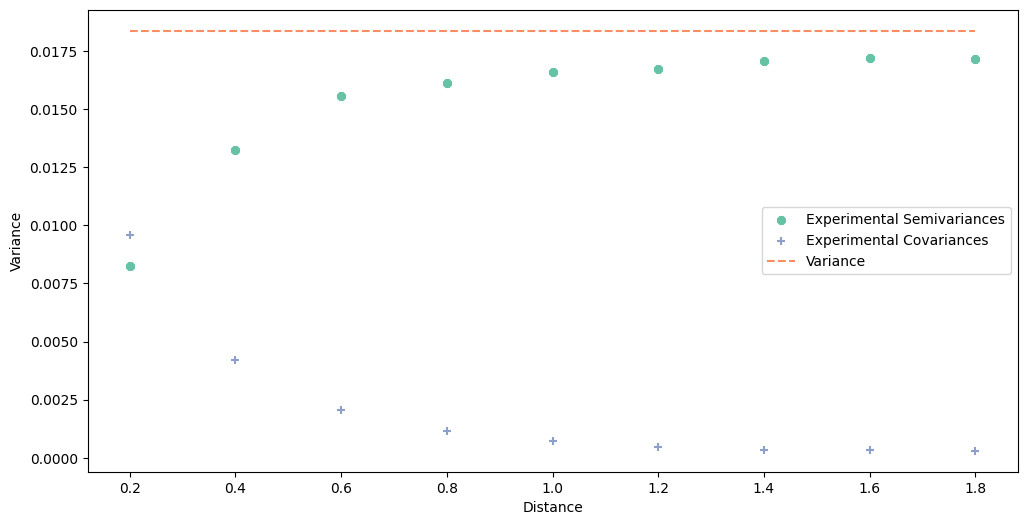


{'model_type': 'spherical', 'nugget': 0, 'sill': 0.0183750931173563, 'rang': 1.7477125111214271, 'fitted_model': array([[0.2       , 0.00314037],
       [0.4       , 0.00619813],
       [0.6       , 0.00909067],
       [0.8       , 0.01173539],
       [1.        , 0.01404966],
       [1.2       , 0.01595089],
       [1.4       , 0.01735645],
       [1.6       , 0.01818375],
       [1.8       , 0.01837509]]), 'rmse': 0.004036430301606162, 'bias': nan, 'mae': nan, 'smape': nan}


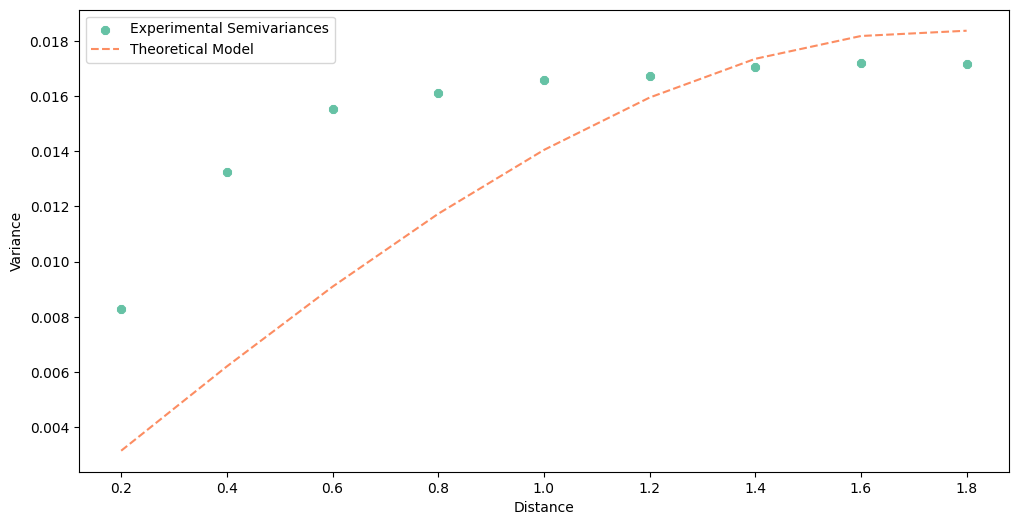

max range=5


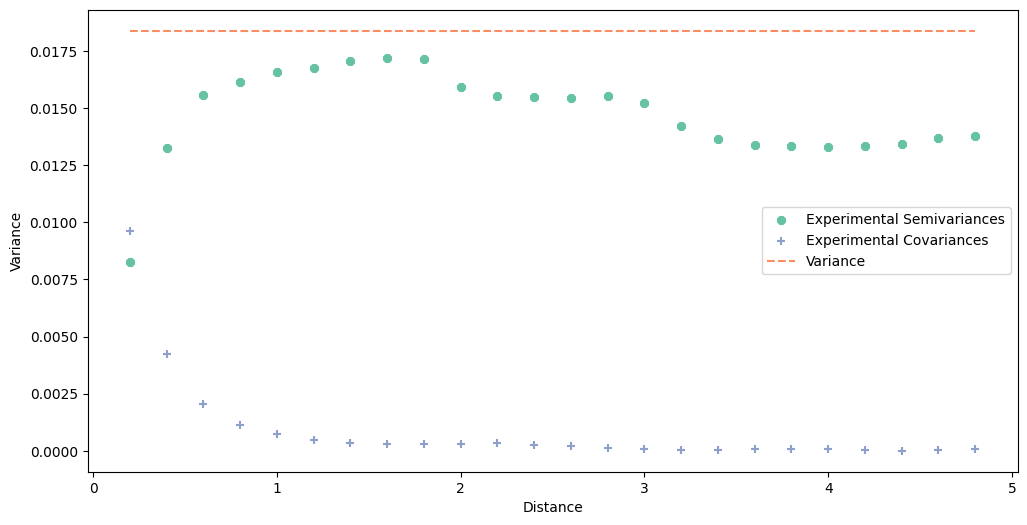


{'model_type': 'spherical', 'nugget': 0, 'sill': 0.01575007981487683, 'rang': 1.7477125111214271, 'fitted_model': array([[2.00000000e-01, 2.69174621e-03],
       [4.00000000e-01, 5.31268414e-03],
       [6.00000000e-01, 7.79200553e-03],
       [8.00000000e-01, 1.00589021e-02],
       [1.00000000e+00, 1.20425655e-02],
       [1.20000000e+00, 1.36721876e-02],
       [1.40000000e+00, 1.48769601e-02],
       [1.60000000e+00, 1.55860746e-02],
       [1.80000000e+00, 1.57500798e-02],
       [2.00000000e+00, 1.57500798e-02],
       [2.20000000e+00, 1.57500798e-02],
       [2.40000000e+00, 1.57500798e-02],
       [2.60000000e+00, 1.57500798e-02],
       [2.80000000e+00, 1.57500798e-02],
       [3.00000000e+00, 1.57500798e-02],
       [3.20000000e+00, 1.57500798e-02],
       [3.40000000e+00, 1.57500798e-02],
       [3.60000000e+00, 1.57500798e-02],
       [3.80000000e+00, 1.57500798e-02],
       [4.00000000e+00, 1.57500798e-02],
       [4.20000000e+00, 1.57500798e-02],
       [4.40000000e+00, 

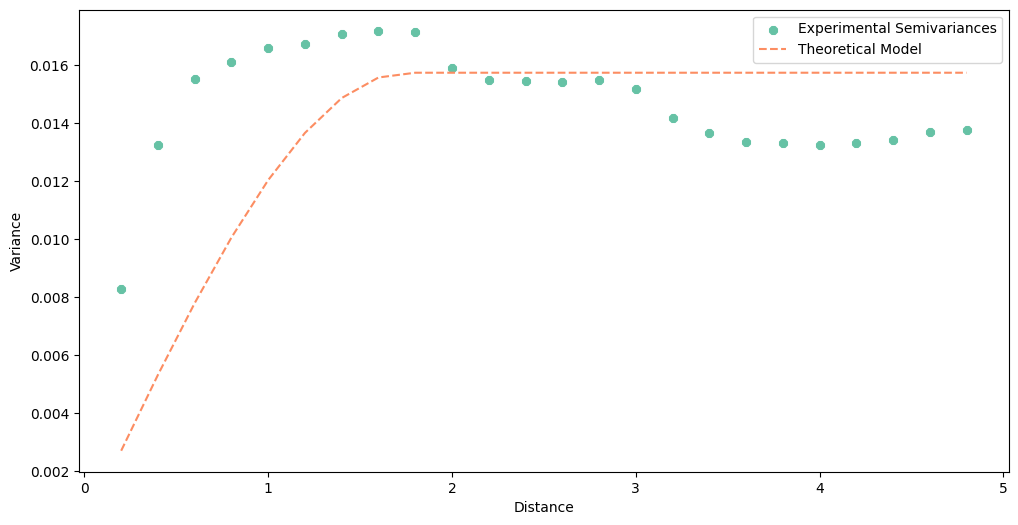

max range=6


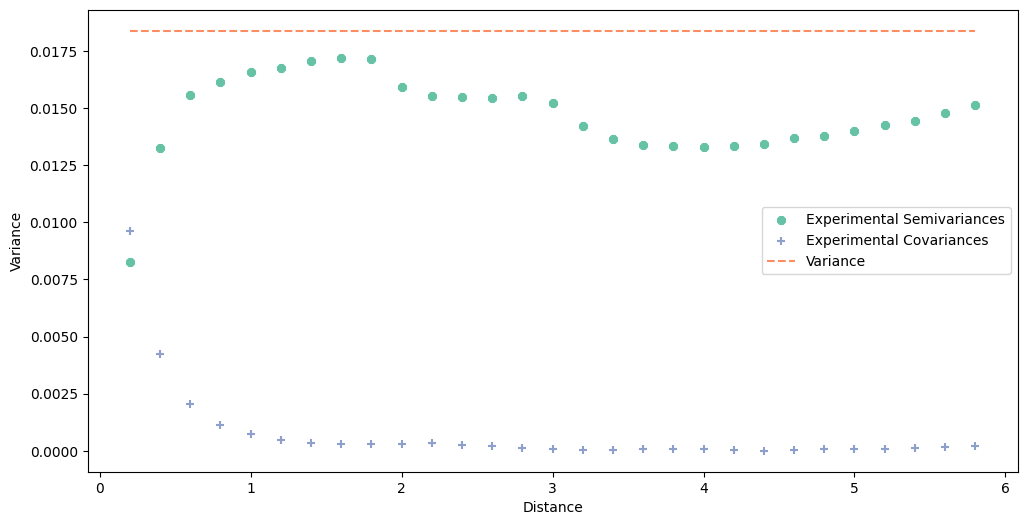


{'model_type': 'spherical', 'nugget': 0, 'sill': 0.015458411670156888, 'rang': 1.7477125111214271, 'fitted_model': array([[2.00000000e-01, 2.64189906e-03],
       [4.00000000e-01, 5.21430110e-03],
       [6.00000000e-01, 7.64770913e-03],
       [8.00000000e-01, 9.87262612e-03],
       [1.00000000e+00, 1.18195551e-02],
       [1.20000000e+00, 1.34189990e-02],
       [1.40000000e+00, 1.46014608e-02],
       [1.60000000e+00, 1.52974436e-02],
       [1.80000000e+00, 1.54584117e-02],
       [2.00000000e+00, 1.54584117e-02],
       [2.20000000e+00, 1.54584117e-02],
       [2.40000000e+00, 1.54584117e-02],
       [2.60000000e+00, 1.54584117e-02],
       [2.80000000e+00, 1.54584117e-02],
       [3.00000000e+00, 1.54584117e-02],
       [3.20000000e+00, 1.54584117e-02],
       [3.40000000e+00, 1.54584117e-02],
       [3.60000000e+00, 1.54584117e-02],
       [3.80000000e+00, 1.54584117e-02],
       [4.00000000e+00, 1.54584117e-02],
       [4.20000000e+00, 1.54584117e-02],
       [4.40000000e+00,

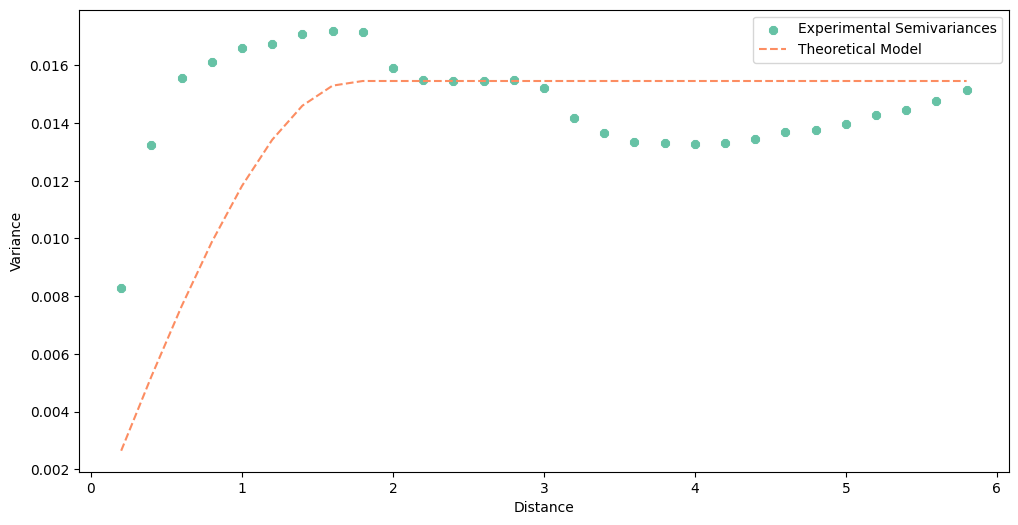

max range=8


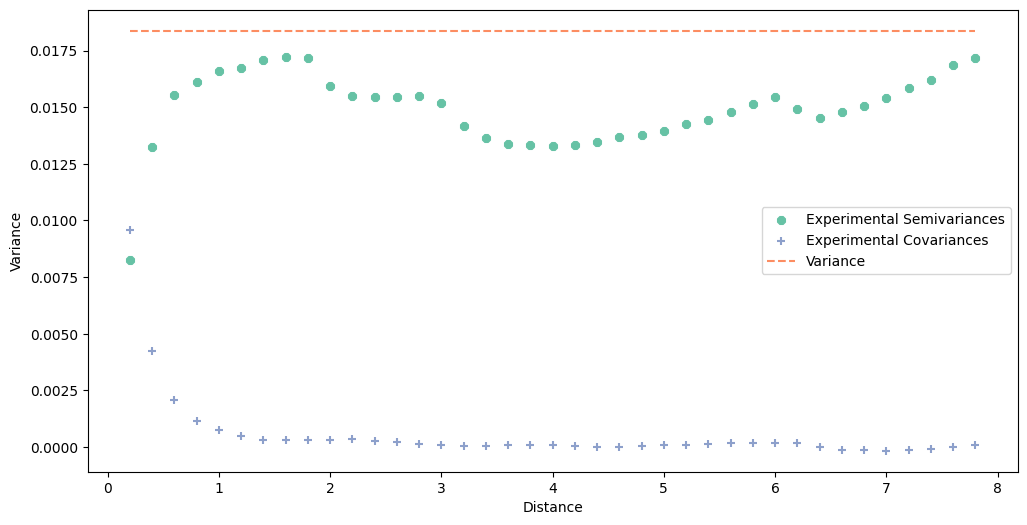


{'model_type': 'spherical', 'nugget': 0, 'sill': 0.015458411670156888, 'rang': 1.7477125111214271, 'fitted_model': array([[2.00000000e-01, 2.64189906e-03],
       [4.00000000e-01, 5.21430110e-03],
       [6.00000000e-01, 7.64770913e-03],
       [8.00000000e-01, 9.87262612e-03],
       [1.00000000e+00, 1.18195551e-02],
       [1.20000000e+00, 1.34189990e-02],
       [1.40000000e+00, 1.46014608e-02],
       [1.60000000e+00, 1.52974436e-02],
       [1.80000000e+00, 1.54584117e-02],
       [2.00000000e+00, 1.54584117e-02],
       [2.20000000e+00, 1.54584117e-02],
       [2.40000000e+00, 1.54584117e-02],
       [2.60000000e+00, 1.54584117e-02],
       [2.80000000e+00, 1.54584117e-02],
       [3.00000000e+00, 1.54584117e-02],
       [3.20000000e+00, 1.54584117e-02],
       [3.40000000e+00, 1.54584117e-02],
       [3.60000000e+00, 1.54584117e-02],
       [3.80000000e+00, 1.54584117e-02],
       [4.00000000e+00, 1.54584117e-02],
       [4.20000000e+00, 1.54584117e-02],
       [4.40000000e+00,

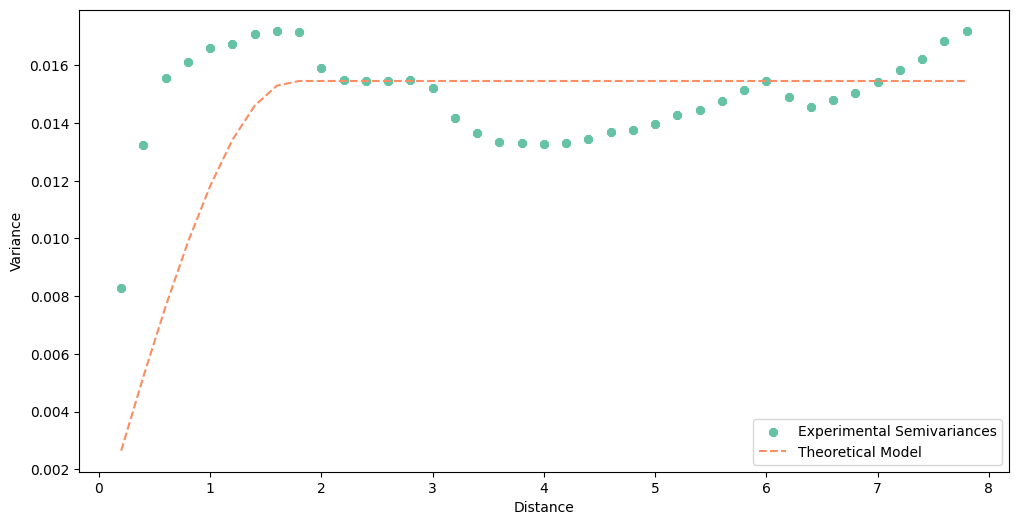

In [5]:
step_radius = 0.2
for max_range in [2, 5, 6, 8]:
    print(f"max range={max_range}")
    experimental_variogram = build_experimental_variogram(input_array=data, step_size=step_radius, max_range=max_range)
    experimental_variogram.plot(plot_semivariance=True, plot_covariance=True, plot_variance=True)
    print()
    semivariogram_model = TheoreticalVariogram()
    fitted = semivariogram_model.autofit(experimental_variogram=experimental_variogram, model_types='all')
    print(fitted)
    semivariogram_model.plot()
    print('='*10)

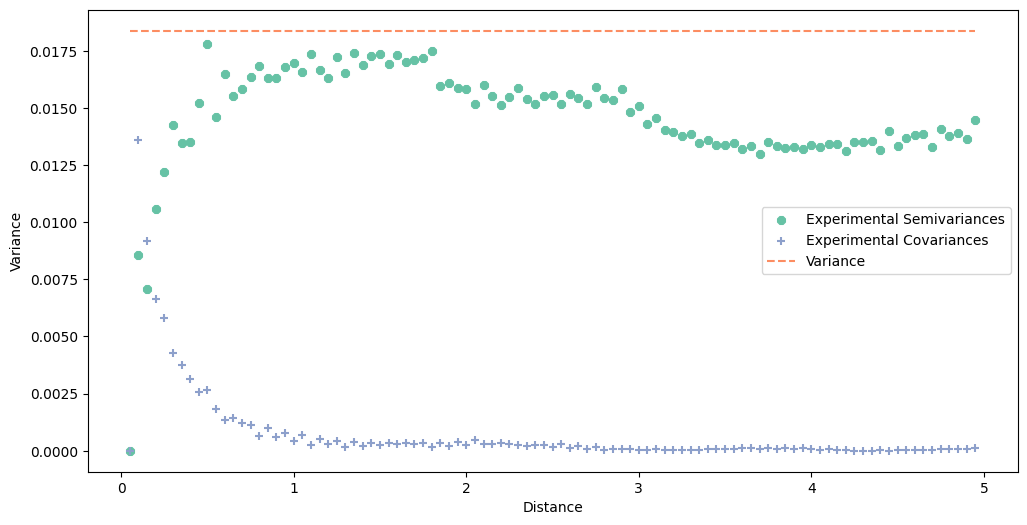

In [7]:
step_radius = 0.05
max_range = 5
experimental_variogram = build_experimental_variogram(input_array=data, step_size=step_radius, max_range=max_range)
experimental_variogram.plot(plot_semivariance=True, plot_covariance=True, plot_variance=True)
semivariogram_model = TheoreticalVariogram()
fitted = semivariogram_model.autofit(experimental_variogram=experimental_variogram, model_types='all')

In [8]:
idx = np.arange(0, data.shape[0]).reshape(-1 ,1)
# np.concatenate([idx, data], axis=1)

In [32]:
# from pyinterpolate import smooth_blocks, area_to_point_pk

# area_to_point_pk(semivariogram_model=semivariogram_model,
#                 blocks=data, point_support=data,
#                 unknown_block=products, unknown_block_point_support=products,
#                 number_of_neighbors=1
#                 )

smoothed = smooth_area_to_point_pk(semivariogram_model=semivariogram_model,
                         blocks=np.concatenate([idx, data], axis=1),
                         point_support=np.concatenate([idx, data], axis=1),
                         number_of_neighbors=16,
                        #  max_range=10000,
                        #  crs=blocks.data.crs,
                         raise_when_negative_error=False,
                         raise_when_negative_prediction=True)

                        

  0%|          | 0/13528 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/pyinterpolate/distance/distance.py:217: RuntimeWarning: invalid value encountered in double_scalars
  distances_sum = np.sum(wdist) / np.sum(w)
 33%|███▎      | 4494/13528 [00:00<00:00, 14180.29it/s]/usr/local/lib/python3.9/site-packages/pyinterpolate/distance/distance.py:217: RuntimeWarning: invalid value encountered in double_scalars
  distances_sum = np.sum(wdist) / np.sum(w)
100%|██████████| 13528/13528 [00:00<00:00, 25179.37it/s]


(0.0, [[(97.1500015258789, 5.449999809265137), 0.4587446395679089, 0.119766997894236]])


TypeError: cannot unpack non-iterable numpy.float64 object

In [33]:
from typing import Union, Dict, Any
from multiprocessing import Pool
import geopandas as gpd
import numpy as np
import pandas as pd

from shapely.geometry import Point
from tqdm import tqdm

from pyinterpolate.kriging.models.block import area_to_point_pk
from pyinterpolate.processing.checks import check_ids
from pyinterpolate.processing.preprocessing.blocks import Blocks, PointSupport
from pyinterpolate.processing.transform.transform import transform_ps_to_dict, transform_blocks_to_numpy
from pyinterpolate.variogram import TheoreticalVariogram



def func(arr_bl, area_id, dict_ps, semivariogram_model, number_of_neighbors, max_range, raise_when_negative_prediction, raise_when_negative_error, err_to_nan) -> tuple[Any, Any]:
    k_areas = arr_bl[arr_bl[:, 0] != area_id].copy()
    exclude_key = {area_id}
    k_points = {k: dict_ps[k] for k in set(list(dict_ps.keys())) - exclude_key}
    u_area = arr_bl[arr_bl[:, 0] == area_id].copy()
    u_points = dict_ps[area_id].copy()

    results = area_to_point_pk(semivariogram_model=semivariogram_model,
                            blocks=k_areas,
                            point_support=k_points,
                            unknown_block=u_area[0][:-1],
                            unknown_block_point_support=u_points,
                            number_of_neighbors=number_of_neighbors,
                            max_range=max_range,
                            raise_when_negative_prediction=raise_when_negative_prediction,
                            raise_when_negative_error=raise_when_negative_error,
                            err_to_nan=err_to_nan)
    return area_id, results

def smooth_area_to_point_pk(semivariogram_model: TheoreticalVariogram,
                            blocks: Union[Blocks, gpd.GeoDataFrame, pd.DataFrame, np.ndarray],
                            point_support: Union[Dict, np.ndarray, gpd.GeoDataFrame, pd.DataFrame, PointSupport],
                            number_of_neighbors: int,
                            max_range=None,
                            crs: Any = None,
                            raise_when_negative_prediction=True,
                            raise_when_negative_error=True,
                            err_to_nan=True) -> gpd.GeoDataFrame:


        
    # Prepare data
    # Transform point support to dict
    if isinstance(point_support, Dict):
        dict_ps = point_support.copy()
    else:
        dict_ps = transform_ps_to_dict(point_support)

    # Transform Blocks to array
    if isinstance(blocks, np.ndarray):
        arr_bl = blocks
    else:
        # Here IDE (PyCharm) gets type inspection wrong...
        # noinspection PyTypeChecker
        arr_bl = transform_blocks_to_numpy(blocks)

    rarr = []
    block_ids = arr_bl[:, 0]
    ps_ids = list(dict_ps.keys())
    possible_idx = set(block_ids) & set(ps_ids)

    possible_len = len(possible_idx)

    if possible_len != len(block_ids) or possible_len != len(ps_ids):
        check_ids(block_ids, ps_ids, set_name_a='Blocks indexes', set_name_b='Point Support indexes')

    with Pool(processes=2) as pool:
        pools = []
        for area_id in tqdm(arr_bl[:, 0]):
            if area_id in possible_idx:

                args = (arr_bl, area_id, dict_ps, semivariogram_model, number_of_neighbors, max_range, raise_when_negative_prediction, raise_when_negative_error, err_to_nan)

                pools.append( pool.apply_async(func, args=args   ) )
                # [res.get(timeout=1) for res in pools]
        for pool_results in pools:
            results = pool_results.get(timeout=30)
            for result in results[1]:
                area_id = results[0]
                pred_arr = [area_id, Point(result[0]), result[1], result[2]]
                rarr.append(pred_arr)

    gdf = gpd.GeoDataFrame(data=rarr, columns=['area id', 'geometry', 'pred', 'err'])
    gdf.geometry = gdf['geometry']

    if crs is not None:
        gdf.set_crs(crs=crs, inplace=True)

    return gdf


In [28]:
from multiprocessing import Pool, TimeoutError
import time
import os

def f(i,x):
    def abc():
        print('abc')
    print(f"{i}: {x}\n")
    abc()
    return x*x

with Pool(processes=5) as pool:
    for i in range(10):
        results = []
        results.append(pool.apply_async(f, args=(i,i)))
        print([res.get(timeout=1) for res in results])

0: 0

abc
1: 1

abc
2: 2

abc
3: 3

abc
4: 4

abc
5: 5

abc
6: 6

abc
7: 7

abc
8: 8

abc
9: 9

abc
[0]
[1]
[4]
[9]
[16]
[25]
[36]
[49]
[64]
[81]
